### CEM ###

In [ ]:
from tqdm import tqdm

In [ ]:
import torch
from torch import nn
import numpy as np
import gym
import random
import matplotlib.pyplot as plt

class CEMContinuous(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.network2 = nn.Sequential(
            nn.Linear(self.state_dim, 64),
            nn.LeakyReLU(),
            nn.Linear(64, self.action_dim),
            nn.Tanh()
        )
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Tanh())
        self.loss = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state, noise_std=0.1):
        state = torch.FloatTensor(state).unsqueeze(0)
        action = self.forward(state).squeeze().detach().numpy()
       # print(action)
        noise =  noise_std * np.random.randn(self.action_dim)
        action += noise
       # print(noise)
        action = np.clip(action, env.action_space.low[0], env.action_space.high[0])
        return action


    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for elite_trajectory in elite_trajectories:
            for state, action in zip(elite_trajectory['states'], elite_trajectory['actions']):
                elite_states.append(state)
                elite_actions.append(action)

        if not elite_states:
            print("No elite states collected. Check the trajectories.")
            return

        elite_states = torch.FloatTensor(np.array(elite_states))
        elite_actions = torch.FloatTensor(np.array(elite_actions))
        for epoch in range(10):
            loss = self.loss(self.forward(elite_states).squeeze(), elite_actions)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()


def get_trajectory(env, agent, trajectory_len, noise_std=0.1, visualize=False):
    trajectory = {'states': [], 'actions': [], 'total_reward': 0}

    state = env.reset()
    trajectory['states'].append(state)

    for _ in range(trajectory_len):
        action = agent.get_action(state, noise_std)
        trajectory['actions'].append(action)

        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward
        if done:
            break

        if visualize:
            env.render()

        trajectory['states'].append(state)

    return trajectory
elite_container = []
def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param)

    for trajectory in trajectories:
        if trajectory['total_reward'] > 200:
            elite_container.append(trajectory)

    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]


env = gym.make('LunarLander-v2', continuous=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]



/Users/jalal/anaconda3/envs/workspace/lib/python3.8/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/jalal/anaconda3/envs/workspace/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


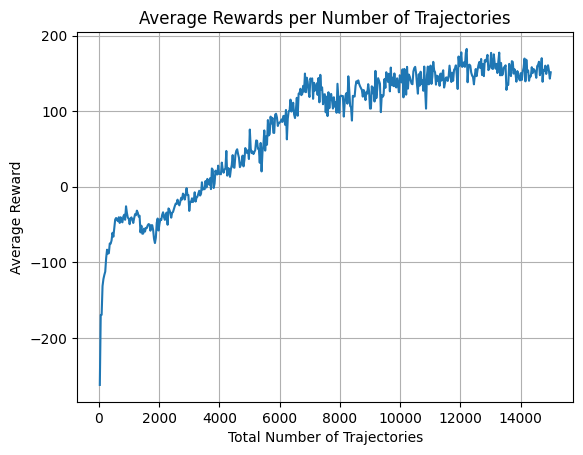

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def run_cem_agent(agent, episode_n, trajectory_n, trajectory_len, start_sigma, end_sigma, start_q, end_q, coef):
    scores = []
    for episode in range(episode_n):
        trajectories = []
        for _ in range(trajectory_n):
            cur = episode
            if cur > coef:
                cur = coef
            noise_std = start_sigma - (start_sigma - end_sigma) * cur / coef
            trajectory = get_trajectory(env, agent, trajectory_len, noise_std)
            trajectories.append(trajectory)

        q_param = start_q + (end_q - start_q) * episode / episode_n
        elite_trajectories = get_elite_trajectories(trajectories, q_param)

        agent.update_policy(elite_trajectories)

        episode_rewards = [trajectory['total_reward'] for trajectory in trajectories]
        mean_reward = np.mean(episode_rewards)
        scores.append(mean_reward)

    return scores

episode_n = 500
trajectory_n = 30
trajectory_len = 500
start_sigma = 0.9
end_sigma = 0.05
start_q = 0.8
end_q = 0.95
coef = episode_n / 2

num_agents = 5
all_scores_CEM = []
for _ in range(num_agents):
    agent = CEMContinuous(state_dim, action_dim)
    agent_scores = run_cem_agent(agent, episode_n, trajectory_n, trajectory_len, start_sigma, end_sigma, start_q, end_q, coef)
    all_scores_CEM.append(agent_scores)

avg_scores = np.mean(np.array(all_scores_CEM), axis=0)

total_trajectories = np.arange(trajectory_n, episode_n * trajectory_n + 1, trajectory_n)

plt.plot(total_trajectories, avg_scores)
plt.title('Average Rewards per Number of Trajectories')
plt.xlabel('Total Number of Trajectories')
plt.ylabel('Average Reward')
plt.grid()
plt.show()


### DQN ###

In [ ]:
import torch.nn as nn
class Qfunction(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.linear_1 = nn.Linear(state_dim, 128)
        self.linear_2 = nn.Linear(128, 128)
        self.linear_3 = nn.Linear(128, action_dim)
        self.activation = nn.ReLU()

    def forward(self, states):
        hidden = self.linear_1(states)
        hidden = self.activation(hidden)
        hidden = self.linear_2(hidden)
        hidden = self.activation(hidden)
        actions = self.linear_3(hidden)
        return actions

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random
import gym


def discretize_action_space(n, action_space):
    main_engine_actions = np.linspace(action_space.low[0], action_space.high[0], n)
    side_engine_actions = np.linspace(action_space.low[1], action_space.high[1], n)

    discrete_actions = []
    for me_action in main_engine_actions:
        for se_action in side_engine_actions:
            discrete_actions.append([me_action, se_action])

    return discrete_actions

class DQNSoft:
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-4, batch_size=64, epsilon_decrease=0.011, epsilon_min=0.001, tau=0.005):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim)
        self.target_q_function = Qfunction(self.state_dim, self.action_dim)
        self.target_q_function.load_state_dict(self.q_function.state_dict())
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.optimizer = torch.optim.Adam(self.q_function.parameters(), lr=lr)
        self.tau = tau

    def soft_update(self, target, source):
        for target_param, local_param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def get_action(self, state, discrete_actions):
        action_index = 0
        if np.random.rand() < self.epsilon:
            action_index = np.random.choice(len(discrete_actions))
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_function(state_tensor)
            action_index = torch.argmax(q_values).item()

        return action_index

    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, int(done), next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))

            targets = rewards + self.gamma * (1 - dones) * torch.max(self.target_q_function(next_states), dim=1).values
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]

            loss = F.smooth_l1_loss(q_values, targets.detach())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            self.epsilon = max(self.epsilon - self.epsilon_decrease, self.epsilon_min)
            self.soft_update(self.target_q_function, self.q_function)

In [ ]:
def run_dqn_agent(env, agent, n_episodes):
    total_rewards = []
    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0

        while True:
            action_index = agent.get_action(state,discrete_actions)
            next_state, reward, done, _ = env.step(discrete_actions[action_index])
            agent.fit(state, action_index, reward, done, next_state)
            state = next_state
            total_reward += reward

            if done:
                break
        total_rewards.append(total_reward)
    return total_rewards

env = gym.make('LunarLanderContinuous-v2')
state_dim = env.observation_space.shape[0]
n_discrete_actions = 6
discrete_actions = discretize_action_space(n_discrete_actions, env.action_space)
action_dim = len(discrete_actions)

n_episodes = 500
num_agents = 5
all_rewards_DQN = []

for _ in range(num_agents):
    agent = DQNSoft(state_dim, action_dim)
    agent_rewards = run_dqn_agent(env, agent, n_episodes)
    all_rewards_DQN.append(agent_rewards)

avg_rewards = np.mean(np.array(all_rewards_DQN), axis=0)

plt.plot(range(n_episodes), avg_rewards)
plt.title('Average Rewards per trajectory generated for DQNSoft Agents')
plt.xlabel('Total Number of Trajectories')
plt.ylabel('Average Reward')
plt.grid()
plt.show()

env.close()

### PPO ###

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Normal


class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, batch_size=128,
                 epsilon=0.5, epoch_n=40, pi_lr=1e-3, v_lr=5e-3):

        super().__init__()

        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * action_dim), nn.Tanh())

        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        pi_output = self.pi_model(torch.FloatTensor(state))
        mean = pi_output[..., :self.action_dim]
        log_std = pi_output[..., self.action_dim:]
        std = torch.exp(log_std)
        dist = Normal(mean, std)
        action = dist.sample()
        return action.numpy()

    def fit(self, states, actions, rewards, dones):

        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])

        pi_output = self.pi_model(states)
        mean = pi_output[:, :self.action_dim]
        log_std = pi_output[:, self.action_dim:]
        std = torch.exp(log_std)
        dist = Normal(mean, std)
        old_log_probs = dist.log_prob(actions).detach().sum(dim=1, keepdim=True)

        for epoch in range(self.epoch_n):
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]

                b_advantage = b_returns.detach() - self.v_model(b_states)

                pi_output = self.pi_model(b_states)
                b_mean = pi_output[:, :self.action_dim]
                b_log_std = pi_output[:, self.action_dim:]
                b_std = torch.exp(b_log_std)
                b_dist = Normal(b_mean, b_std)
                b_new_log_probs = b_dist.log_prob(b_actions).sum(dim=1, keepdim=True)

                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))

                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()

                v_loss = torch.mean(b_advantage ** 2)

                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt


def run_ppo_agent(agent, episode_n, trajectory_n):
    total_rewards_per_trajectory = []

    for episode in range(episode_n):
        states, actions, rewards, dones = [], [], [], []

        for _ in range(trajectory_n):
            total_reward = 0
            state = env.reset()
            for t in range(500):
                action = agent.get_action(state)
                next_state, reward, done, _ = env.step(action * 2)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                dones.append(done)

                state = next_state
                total_reward += reward

                if done:
                    break

            total_rewards_per_trajectory.append(total_reward)

        agent.fit(states, actions, rewards, dones)

    return total_rewards_per_trajectory

env = gym.make('LunarLander-v2', continuous=True)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

episode_n = 15
trajectory_n = 200

num_agents = 5
all_rewards_PPO = []

for _ in range(num_agents):
    agent = PPO(state_dim, action_dim, gamma=0.99)
    agent_rewards = run_ppo_agent(agent, episode_n, trajectory_n)
    all_rewards_PPO.append(agent_rewards)

avg_rewards = np.mean(np.array(all_rewards_PPO), axis=0)

total_trajectories = np.arange(1, episode_n * trajectory_n + 1)

plt.plot(total_trajectories, avg_rewards)
plt.title('Average Rewards per Number of Trajectories for PPO Agents')
plt.xlabel('Total Number of Trajectories')
plt.ylabel('Average Reward')
plt.grid()
plt.show()

env.close()


### SAC ###

In [ ]:
import gym
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from torch.distributions import Normal

class SAC(nn.Module):
    def __init__(self, state_dim, action_dim,hidden_dim=8, gamma=0.99, initial_alpha=5e-3, tau=1e-2,
                 batch_size=64, pi_lr=1e-3, q_lr=1e-3, min_alpha = 0.01, alpha_decay_rate = 0.0003):
        super().__init__()

        self.pi_model = nn.Sequential(nn.Linear(state_dim, hidden_dim), nn.ReLU(),
                                      nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                      nn.Linear(hidden_dim, 2 * action_dim), nn.Tanh())

        self.q1_model = nn.Sequential(nn.Linear(state_dim + action_dim, hidden_dim), nn.ReLU(),
                                      nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                      nn.Linear(hidden_dim, 1))

        self.q2_model = nn.Sequential(nn.Linear(state_dim + action_dim, hidden_dim), nn.ReLU(),
                                      nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                      nn.Linear(hidden_dim, 1))
        self.hidden_dim = hidden_dim
        self.gamma = gamma
        self.alpha = initial_alpha
        self.min_alpha = min_alpha
        self.alpha_decay_rate = alpha_decay_rate
        self.tau = tau
        self.batch_size = batch_size
        self.memory = []
        self.prev_alpha = 0.0
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), pi_lr)
        self.q1_optimizer = torch.optim.Adam(self.q1_model.parameters(), q_lr)
        self.q2_optimizer = torch.optim.Adam(self.q2_model.parameters(), q_lr)
        self.q1_target_model = deepcopy(self.q1_model)
        self.q2_target_model = deepcopy(self.q2_model)

    def update_alpha(self):
        self.alpha = max(self.min_alpha, self.alpha - self.alpha_decay_rate)
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action, _ = self.predict_actions(state)
        action = action.squeeze(0).detach().numpy()
        return action
    def random_alpha(self):
        self.prev_alpha = self.alpha
        self.alpha = 0.6
    def unrandomize_alpha(self):
        self.alpha = self.prev_alpha
    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, done, next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.FloatTensor, zip(*batch))
            rewards, dones = rewards.unsqueeze(1), dones.unsqueeze(1)

            next_actions, next_log_probs = self.predict_actions(next_states)
            next_states_and_actions = torch.concatenate((next_states, next_actions), dim=1)
            next_q1_values = self.q1_target_model(next_states_and_actions)
            next_q2_values = self.q2_target_model(next_states_and_actions)
            next_min_q_values = torch.min(next_q1_values, next_q2_values)
            targets = rewards + self.gamma * (1 - dones) * (next_min_q_values - self.alpha * next_log_probs)

            states_and_actions = torch.concatenate((states, actions), dim=1)
            q1_loss = torch.mean((self.q1_model(states_and_actions) - targets.detach()) ** 2)
            q2_loss = torch.mean((self.q2_model(states_and_actions) - targets.detach()) ** 2)
            self.update_model(q1_loss, self.q1_optimizer, self.q1_model, self.q1_target_model)
            self.update_model(q2_loss, self.q2_optimizer, self.q2_model, self.q2_target_model)

            pred_actions, log_probs = self.predict_actions(states)
            states_and_pred_actions = torch.concatenate((states, pred_actions), dim=1)
            q1_values = self.q1_model(states_and_pred_actions)
            q2_values = self.q2_model(states_and_pred_actions)
            min_q_values = torch.min(q1_values, q2_values)
            pi_loss = - torch.mean(min_q_values - self.alpha * log_probs)
            self.update_model(pi_loss, self.pi_optimizer)

    def update_model(self, loss, optimizer, model=None, target_model=None):
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if model != None and target_model != None:
            for param, terget_param in zip(model.parameters(), target_model.parameters()):
                new_terget_param = (1 - self.tau) * terget_param + self.tau * param
                terget_param.data.copy_(new_terget_param)

    def predict_actions(self, states):
        policy_outputs = self.pi_model(states)
        action_dim = policy_outputs.shape[1] // 2
        means, log_stds = policy_outputs[:, :action_dim], policy_outputs[:, action_dim:]
        stds = torch.exp(log_stds.clamp(-20, 2))
        dists = Normal(means, stds)
        actions = dists.rsample()
        log_probs = dists.log_prob(actions).sum(axis=-1, keepdim=True)
        return actions, log_probs

In [ ]:
def train_algo(agent,total_rewards,episode_n):
    for episode in tqdm(range(episode_n)):
        total_reward = 0
        state = env.reset()

        for t in range(1000):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.fit(state, action, reward, done, next_state)
            if(reward>50):
                print("WE DID IT")
            total_reward += reward
            state = next_state
            if done:
                break
        agent.update_alpha()

        print(total_reward)
        total_rewards.append(total_reward)

In [ ]:
env = gym.make('LunarLander-v2', continuous=True)
def train_and_evaluate(agent, episode_n):
    total_rewards = []
    train_algo(agent,total_rewards,episode_n)
    return total_rewards

episode_n = 600

agents = [SAC(state_dim, action_dim, hidden_dim=128, gamma=0.99, initial_alpha=0.3, tau=1e-2, batch_size=64, pi_lr=1e-3, q_lr=1e-3) for _ in range(5)]

all_rewards_SAC = [train_and_evaluate(agent, episode_n) for agent in agents]

### Output ###

In [ ]:
import pickle
def load_rewards(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

rewards_sac = load_rewards('total_rewards_SAC.pkl')
rewards_dqn = load_rewards('total_rewards_DQN.pkl')
rewards_PPO = load_rewards('total_rewards_PPO.pkl')
rewards_CEM = load_rewards('total_rewards_CEM.pkl')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

def plot_moving_average_rewards(agent_rewards_dict, window_size=20):
    plt.figure(figsize=(10, 6))

    for agent_name, rewards in agent_rewards_dict.items():
        avg_rewards_per_episode = np.mean(rewards, axis=0)
        if agent_name =='CEM':
            avg_scores = np.mean(np.array(all_scores_CEM), axis=0)
            total_trajectories = np.arange(trajectory_n, episode_n * trajectory_n + 1, trajectory_n)
            plt.plot(total_trajectories, avg_scores, label=f'Average Across {agent_name}')
        #elif agent_name=='PPO':
         #   avg_rewards = np.mean(np.array(rewards_PPO), axis=0)
         #   total_trajectories = np.arange(1, episode_n * trajectory_n + 1)
         #   plt.plot(total_trajectories, avg_rewards)
        else:
            ma_rewards = moving_average(avg_rewards_per_episode, window_size)
            plt.plot(ma_rewards, label=f'Average Across {agent_name}')

    plt.title(f"Moving Average of generated trajectories over last {window_size} Episodes")
    plt.xlabel("trajectory")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)
    plt.show()


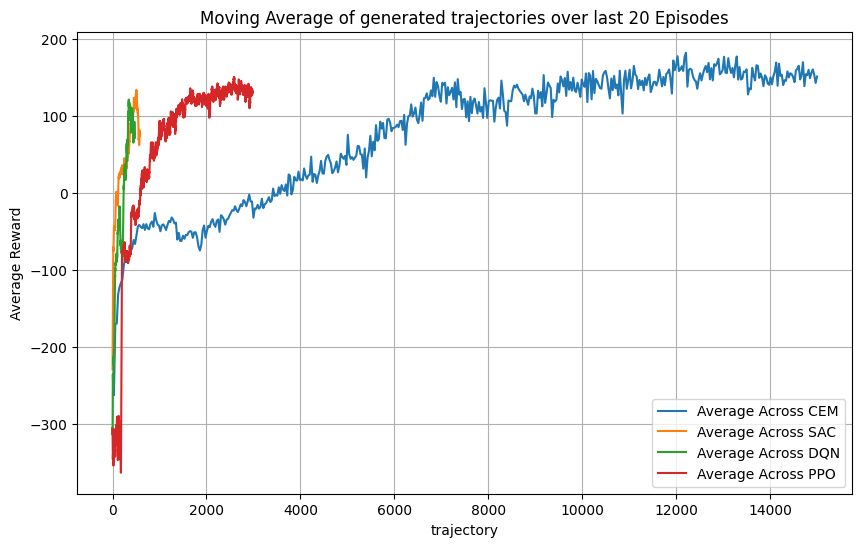

In [ ]:
agent_rewards = {
    'CEM': rewards_CEM,
    'SAC': rewards_sac,
    'DQN': rewards_dqn,
    'PPO': rewards_PPO
}

plot_moving_average_rewards(agent_rewards, window_size=20)

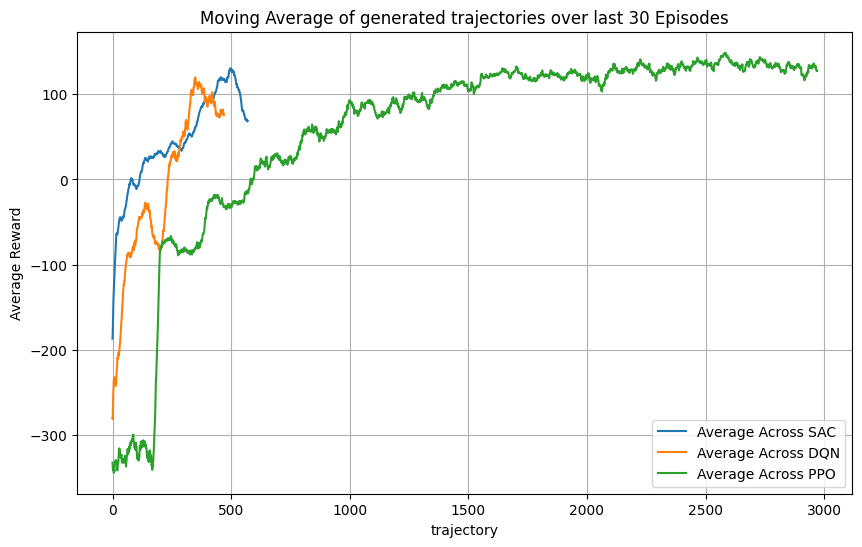

In [ ]:
agent_rewards = {
    'SAC': rewards_sac,
    'DQN': rewards_dqn,
    'PPO': rewards_PPO
}

plot_moving_average_rewards(agent_rewards, window_size=30)